# Demonstration of extended geoDB openEO backend capabilities + Use Case #2

This notebook demonstrates how the extended capabilities of the geoDB openEO backend can be used in a real-world-like use case: data from a vector cube is (temporally) aggregated and used alongside with Sentinel-3 raster data. Apart from this main use case, additional capabilities of the geoDB openEO backend are shown.  

### Preparations
First, the openeo-client software is imported; it is used throughout the notebook to interact with the geoDB openEO backend. Then, the openeo client is used to open connections to the geoDB openEO backend and to the Copernicus Data Space Ecosystem backend, which provides the raster data used in this example.

In [195]:
import openeo

geodb_url = 'https://geodb.openeo.dev.brockmann-consult.de'
geodb = openeo.connect(geodb_url)

cdse_url = 'https://openeo.dataspace.copernicus.eu/'
cdse = openeo.connect(cdse_url)
cdse.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

### Load and aggregate vector data

The following three lines demonstrate the aggregation capabilities of the geoDB openEO backend. Note that the whole process only starts as soon as the processing is triggered by the `download` command. First, the server is notified that the collection shall be loaded. In the second step, the collection is temporally aggregated. The three parameters of the `aggregate_temporal`- function are:
1) `temporal intervals` (`[['2000-01-01', '2030-01-05']]`): all data that falls in these intervals are aggregated.
2) `reducer` (`mean`): a 'reducer' function which aggregates the collected temporal data, i.e. computes a single value from a set of input values. Typical functions are `mean`, `median`, `std`, ...
3) `context` (`{'pattern': '%Y-%M-%d'}`): any context; used here exemplarily to provide the date pattern  

The collection is an artificial collection made for demo purposes. It is a cube of 8 features, containing population info for 4 different points in time, for two geometries (more or less Western and Eastern Hamburg):

![openeo_pop_hamburg](images/openeo_pop_hamburg.png)


In [197]:
hamburg = geodb.load_collection('openeo~pop_hamburg')
hamburg = hamburg.aggregate_temporal([['2000-01-01', '2030-01-05']], 'mean', context={'pattern': '%Y-%M-%d'})
hamburg.download('./hamburg_mean.json', 'GeoJSON')

C:\Users\Thomas\micromamba\envs\xcube-geodb-openeo\lib\site-packages\openeo\metadata.py:272: UserWarning: Unknown dimension type 'geometry'
  complain("Unknown dimension type {t!r}".format(t=dim_type))


### Prepare raster data

Next, the CDSE openEO backend is used to load a small sample of OLCI L1 data. This data is used to compute the NDVI over the Hamburg area, temporally aggregating the first 5 days in 2020. This data will be used in conjunction with the vector data prepared above.

In [198]:
olci = cdse.load_collection("SENTINEL3_OLCI_L1B",
                            spatial_extent={"west": 9.7, "south": 53.3, "east": 10.3, "north": 53.8},
                            temporal_extent=["2020-01-01", "2020-01-05"],
                            bands=["B08", "B17"])

olci_ndvi = olci.ndvi(nir="B17", red="B08")
ndvi_temp_agg = olci_ndvi.aggregate_temporal([["2020-01-01T00:00:00.000Z", "2020-01-05T00:00:00.000Z"]], 'median')

### Use the vector data for spatial aggregation of the raster data

Now we use the vector data produced by the geoDB openEO backend to determine the geometries over which the NDVI data shall be extracted.
As the job is pretty small, it will finish after a short while.

In [199]:
import json
with open('./hamburg_mean.json') as f:
    geometries = json.load(f)
ndvi_final = ndvi_temp_agg.aggregate_spatial(geometries, openeo.processes.ProcessBuilder.mean)
result = ndvi_final.save_result(format = "GTiff")
job = result.create_job()
job.start_and_wait()

0:00:00 Job 'j-231121366e30458cba494dc68f586106': send 'start'
0:00:14 Job 'j-231121366e30458cba494dc68f586106': created (progress N/A)
0:00:19 Job 'j-231121366e30458cba494dc68f586106': created (progress N/A)
0:00:26 Job 'j-231121366e30458cba494dc68f586106': running (progress N/A)
0:00:34 Job 'j-231121366e30458cba494dc68f586106': running (progress N/A)
0:00:45 Job 'j-231121366e30458cba494dc68f586106': running (progress N/A)
0:00:57 Job 'j-231121366e30458cba494dc68f586106': running (progress N/A)
0:01:13 Job 'j-231121366e30458cba494dc68f586106': running (progress N/A)
0:01:32 Job 'j-231121366e30458cba494dc68f586106': running (progress N/A)
0:01:56 Job 'j-231121366e30458cba494dc68f586106': running (progress N/A)
0:02:34 Job 'j-231121366e30458cba494dc68f586106': finished (progress N/A)


<BatchJob job_id='j-231121366e30458cba494dc68f586106'>

### Download the NDVI data, and prepare for visualisation

In this step, the NDVI data we just produced are downloaded. It is a very small JSON file that simply contains the aggregated NDVI values for all the geometries of the vector cube `openeo~hamburg`. There are two of those, so the JSON file contains only two values.

In [200]:
result_file = job.get_results().download_files("output")[0]
with open(str(result_file)) as f:
    aggregated_ndvi = json.load(f)
ndvi = list([v[0] for v in aggregated_ndvi[list(aggregated_ndvi.keys())[0]]])

### Prepare the vector data for visualisation

The vector data are openend as GeoDataFrame, which allows for visualisation. The NDVI data is added to the DataFrame, so the vector and (aggregated) raster data can be shown together.


In [201]:
import geopandas
gdf = geopandas.read_file('./hamburg_mean.json')
gdf['ndvi'] = ndvi

### Visualise

Finally, we draw the geometries on a map. The aggregated 'population' information that we have extracted from the geoDB openEO backend are displayed in an overlay. The colors represent the NDVI values we received from the CDSE openEO backend. 


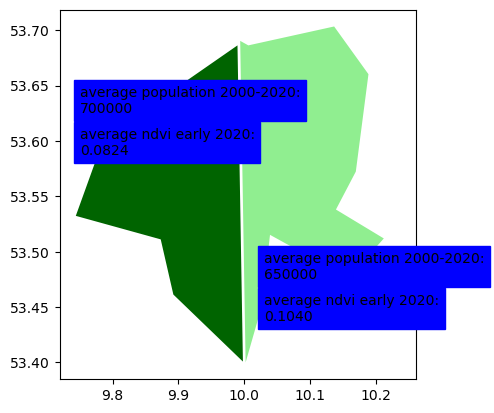

In [208]:
import matplotlib.pyplot as plt
gdf['color'] = ['#006400', '#90EE90']
gdf.plot(legend=True, color=gdf['color'])
va = ['bottom', 'top']
for idx, row in gdf.iterrows():
    coords = {0: (9.75, 53.65),
              1: (10.03, 53.5)}
    plt.annotate('average population 2000-2020:\n' + str(int((row['population']))), xy=coords[idx],
                 horizontalalignment='left', verticalalignment='top', backgroundcolor='b')
for idx, row in gdf.iterrows():
    coords = {0: (9.75, 53.585),
              1: (10.03, 53.435)}
    plt.annotate('average ndvi early 2020:\n' + f'{row["ndvi"]:.4f}', xy=coords[idx],
                 horizontalalignment='left', verticalalignment='bottom', backgroundcolor='b') 

### Math

We can also do simple math on vector cubes provided by the geoDB openEO backend. In the following code, we define two functions (`apply_scaling`and `add_offset`), and apply those functions to the vector cube. We download the results and inspect the datacube. Only those data to which the functions can be applied to are scaled: `population` has been scaled, but `id`, `geometry`, and `date` are left untouched.


In [212]:
def apply_scaling(x: float) -> float:
    return x * 0.000001

def add_offset(x):
    return x + 1.2345

hamburg_scale = geodb.load_collection('openeo~pop_hamburg')
hamburg_scale = hamburg_scale.apply(lambda x: apply_scaling(x))
hamburg_scale.download('./hamburg_scaled.json', 'GeoJSON')

gdf = geopandas.read_file('./hamburg_scaled.json')
gdf[['id', 'geometry', 'population', 'date']]

C:\Users\Thomas\micromamba\envs\xcube-geodb-openeo\lib\site-packages\openeo\metadata.py:272: UserWarning: Unknown dimension type 'geometry'
  complain("Unknown dimension type {t!r}".format(t=dim_type))


,id,geometry,population,date
0,1,"POLYGON ((9.78652 53.60253, 9.98977 53.68638, ...",0.2,1990-01-01 00:00:00+00:00
1,2,"POLYGON ((9.78652 53.60253, 9.98977 53.68638, ...",0.4,2000-01-01 00:00:00+00:00
2,3,"POLYGON ((9.78652 53.60253, 9.98977 53.68638, ...",0.5,2010-01-01 00:00:00+00:00
3,4,"POLYGON ((9.78652 53.60253, 9.98977 53.68638, ...",0.9,2020-01-01 00:00:00+00:00
4,5,"POLYGON ((9.99389 53.69045, 10.00213 53.39996,...",0.4,1990-01-01 00:00:00+00:00
5,6,"POLYGON ((9.99389 53.69045, 10.00213 53.39996,...",0.9,2000-01-01 00:00:00+00:00
6,7,"POLYGON ((9.99389 53.69045, 10.00213 53.39996,...",0.5,2010-01-01 00:00:00+00:00
7,8,"POLYGON ((9.99389 53.69045, 10.00213 53.39996,...",0.8,2020-01-01 00:00:00+00:00
